In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from BoreholeFlow import BhFlow
import quadprog as qp
from BoreholeFlow import PlotFigures
np.set_printoptions(precision=15)
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size

In [2]:
# Created by Joshua Thompson 
# Last updated 09/02/2022

# -----------------------------------------------------
# EXAMPLE 3
# -----------------------------------------------------
alph = 1e-3
nskip = 2

R0 = 1000 # radius of influence for pumping (cm)
Rw = 20.32 / 2 # radius of well (cm)
dhtotal = 2.5 # drop in head from top to bottom of aquifer driving vertical flow

# Flow under ambient conditions
zpump = -100 * np.ones((1,1))
Qpump = np.zeros((1,1))
zobs = -100 * np.ones((1,1))
Qsampling = np.zeros((1,1))

nflows = len(Qpump)
zwellbot = -5000 # depth at bottom of screen

# Hydraulic conductivity (cm/s)
K = [1e-5, 3e-5, 6e-5, 1e-4, 1e-4, 1e-4, 1e-4, 1e-4, 1e-4, 6e-5, 1e-5, 6e-5, 1e-4, 1e-4, 1e-4, 1e-4, 1e-4, 1e-4, 6e-5, 3e-5, 6e-5, 1e-4, 1e-4, 1e-4, 1e-4]
K = np.array([i * 100 for i in K]).reshape(25, 1) # apply list comprehension for multiplying 100 by each element in list.

# True concentration in the aquifer (mg/cm^3)
C0 = np.array([500, 400, 300, 250, 40, 25, 30, 50, 150, 400, 500, 300, 50, 40, 30, 25, 50, 150, 300, 500, 300, 150, 40, 30, 20])
# C0 = C0.reshape((len(C0), 1))

# -----------------------------------------------------
# Instantiate the class
# -----------------------------------------------------
p = BhFlow(K, R0, Rw)

# Define number of layers based on the number of Ks
nlayers = p.NumberOfLayers()

# Create thickness of each wellbore interval
b = 200 * p.NlayersOnesArray(nlayers)

In [3]:
# Define layer head drops.
Keff = np.sum(b) / np.sum(b / K) # effective hydraulic conductivity

dh = Keff/K * b/np.sum(b) * dhtotal # head drops

h0 = p.NlayersZerosArray(nlayers) # Far field heads (in Aquifer)
h0[0] = dh[0] / 2 + 10000
for i in np.arange(1,nlayers):
    h0[i] = h0[i-1] + dh[i-1]/2 + dh[i]/2

ztop, zmid, zbot = p.Discretize(zwellbot, nlayers, b) # Discretize the well

# Run the borehole flow model
QbAmbient, QrAmbient, hAmbient, zmid, zbot, ztop = p.BoreholeFlowModel(nlayers, b, h0, zwellbot, ztop, zmid, zbot, zobs, zpump, Qpump, Qsampling)

In [4]:
zobs = np.arange(b[0] / 2, np.sum(b) - b[-1]/2 + 1, nskip * b[0]) + zwellbot
nobs = len(zobs)
Qsampling = 100 / 60

# Create empty list to store data
ctrueAll, cobsAll, gAll, zobsAll, zpumpAll, QpumpAll, QobsAll, QbAll, QrAll, hAll = p.MakeDataLists()

for i in range(len(zobs)):
    # Run flow model
    Qb, Qr, h, zmid, zbot, ztop= p.BoreholeFlowModel(nlayers, b, h0, zwellbot, ztop, zmid, zbot, zobs[i], zpump, Qpump, Qsampling)
    # Run transport model
    c, cobs, G = p.BoreholeTransportModel(nlayers, b, Qb, Qr, C0, ztop, zmid, zbot, zobs[i], zpump, Qpump, Qsampling)
    # Append data to empty lists
    ctrueAll, cobsAll, gAll, zobsAll, zpumpAll, QpumpAll, QobsAll, QbAll, QrAll, hAll = p.AppendData(c, cobs, G, zobs[i], zpump, Qpump, Qsampling, Qb, Qr, h, ctrueAll, cobsAll, gAll, zobsAll, zpumpAll, QpumpAll, QobsAll, QbAll, QrAll, hAll)
    
# Convert list to array and transpose data
ctrueLF1, cobsLF1, GLF1, zobsLF1, zpumpLF1, QpumpLF1, QobsLF1, QbLF1, QrLF1, hLF1 = p.Convert2Arrays(zobs, nlayers, ctrueAll, cobsAll, gAll, zobsAll, zpumpAll, QpumpAll, QobsAll, QbAll, QrAll, hAll)

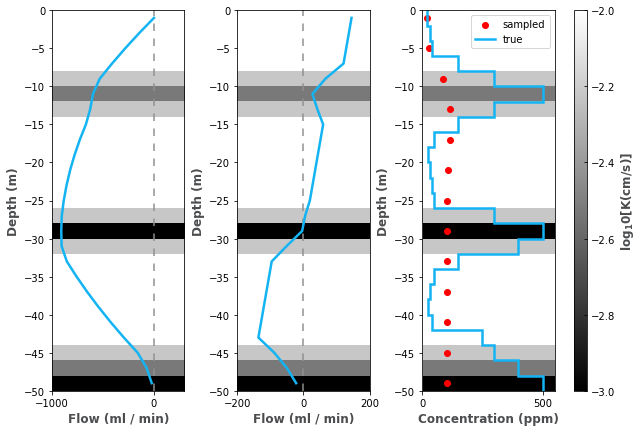

In [5]:
plot = PlotFigures()
plot.PlotFigure3(C0, K, QbAmbient, zmid, QrAmbient, cobsLF1, zobsLF1)

In [6]:
# -----------------------------------------------------
# EXPORTING FOR DATA VALIDATION
# -----------------------------------------------------
# path = r'C:\Users\thom675\OneDrive - PNNL\summer_internship_2022\borehole flow\Python\python_output'
# file_name1 = '\Python_Output_Fig3_QbLF1.txt'
# file_name2 = '\Python_Output_Fig3_QrLF1.txt'
# file_name3 = '\Python_Output_Fig3_ctrue.txt'
# file_name4 = '\Python_Output_Fig3_cobs.txt'

# np.savetxt(path + file_name1, QbLF1)
# np.savetxt(path + file_name2, QrLF1)
# np.savetxt(path + file_name3, ctrueLF1)
# np.savetxt(path + file_name4, cobsLF1)